# Lecture 8: General tricks for efficient training

## Previous lecture:  Graph Neural Networks
- Deep learning on graphs
- Basic models
- Applications

## General tricks for efficient training:
- Data augmentation
- Self-training
- Gradient clipping 
- multi-precision training

## Regularization techniques

- dropout
- weight decay
- and early stopping


## Dropout

Dropout is a classical technique for the regularization of deep neural network training, proposed in [Dropout: A Simple Way to Prevent Neural Networks from
Overfitting, Nitish Srivastava, Geoffrey Hinton, Alex Krizhevsky, Ilya Sutskever,Ruslan Salakhutdinov](https://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)

The idea is to randomly zero out **activations** in a neural network.

In this case, the inference becomes stochastic, and the overfitting to particular neurons is less possible.

Although new zeros appear, it typically does not reduce the complexity.

## Weight decay

[Weight decay technique](https://arxiv.org/pdf/1711.05101.pdf) is a very useful regularization technique for deep neural networks.

They should be well incorporated into the optimization algorithm. The reference above proposes AdamW and SGDW versions of Adam and SGD type methods.

## Working on the optimizer level

The hyperparameter selection for the deep neural network optimizer is extremely important.

A good advice is to do grid search / hyperparameter optimization for optimal selection.

One of the important properties of the optimizer is learning rate schedulers. 

Every data scientist has a favourite way of doing it (together with the favourite method).

A good tutorial can be found [here](https://neptune.ai/blog/how-to-choose-a-learning-rate-scheduler) and [here](https://docs.mosaicml.com/en/latest/trainer/schedulers.html).

Lets have a look at the latter.

## The concept of data augmentation in image classification

- We have limited data
- The more data we have, the better quality
- Modern models are not robust to image augmentation by translation/rotation/...
- Data augmentations 

## List of main data augmentations

<img src='data-aug.webp'>

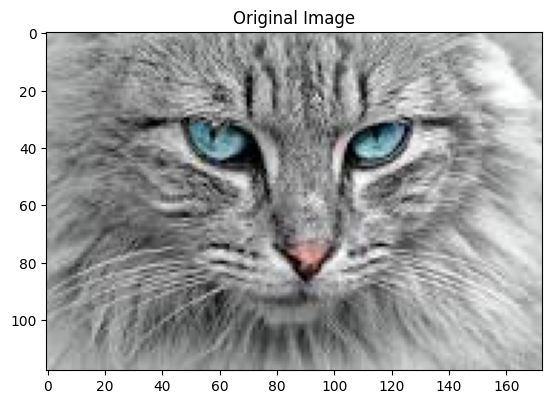

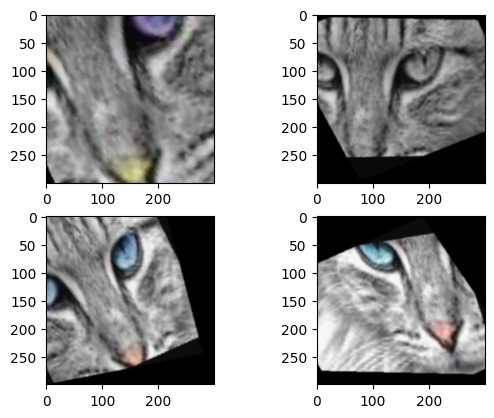

In [22]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import requests
import random

# Download the image
#url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/9/9a/Taj_Mahal_%28Edited%29.jpeg/1280px-Taj_Mahal_%28Edited%29.jpeg'
#img = Image.open(requests.get(url, stream=True).raw)

img = Image.open('cute-cat.jpeg')
# Define augmentations
transform = transforms.Compose([
    transforms.Resize(size=(512, 512)),
    transforms.RandomCrop(size=300),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomAffine(degrees=30, translate=(0.2, 0.2), scale=(0.8, 1.2)),
    transforms.RandomPerspective(distortion_scale=0.2),
    transforms.RandomResizedCrop(size=300, scale=(0.5, 1.0)),
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(kernel_size=3)
])

# Plot original image
plt.imshow(img)
plt.title("Original Image")
plt.show()

# Plot augmented images
for i in range(4):
    augmented_img = transform(img)
    plt.subplot(2, 2, i+1)
    plt.imshow(augmented_img)
   # plt.title(f"Augmentation {i+1}")
plt.show()

## Augmentation and how it helps.
In the original ImageNet paper: randomly crop 224x224 patches from image, flipping and PCA color augmentation.

This increased the dataset by a factor of 2048.

Data Augmentation can significantly improve the quality of image classifier. 

But how to select the hypeparameters? 


## AutoAugment

[AutoAugment: Learning Augmentation Policies from Data
Ekin D. Cubuk, Barret Zoph, Dandelion Mane, Vijay Vasudevan, Quoc V. Le](https://arxiv.org/abs/1805.09501) 

It is a good idea to use different data augmentation techniques for different types of data.

For example, horizontal flipping of images is useful during training for CIRAR-10, but not for MNIST (different types of data).

So, it is a good idea to adapt augmentation techniques for a dataset.

## AutoAugment: idea

AutoAugment consists of two components:

1. **Search algorithm** (implementead as **controller-RNN**) which samples a data augmentation policy: what image processing operation to use, probability of using the operation and magnitude. A neural network is trained and its validation is sent back. **Reinforcement learning** can be used.

2. **Search space**: 5 sub-policies, each policy has 2 operations. 

## RandAugment

[RandAugment](https://openaccess.thecvf.com/content_CVPRW_2020/html/w40/Cubuk_Randaugment_Practical_Automated_Data_Augmentation_With_a_Reduced_Search_Space_CVPRW_2020_paper.html) provides a constructive way of selection of optimal random augmentation.

The main message is that the search algorithm is not that important than **search space** of possible augmentation strategies.

They basically replace the sophisticated reinforcement learning algorithm with a pure random search over all possible policies.

The magnitude is selected the same for all transformations (????)

## Data augmentation in NLP

The NLP domain is completely different, so completely different techniques have to be used.

Some of the tricks:

- Backtranslation
- Simple tricks
- Albumentations

## Simple tricks (taken from https://neptune.ai/blog/data-augmentation-nlp)

### Synonym Replacement
Randomly choose $n$ words from the sentence that are not stop words. Replace each of these words with one of its synonyms chosen at random. 

For example, given the sentence:

```This article will focus on summarizing data augmentation techniques in NLP.```

The method randomly selects n words (say two), the words article and techniques, and replaces them with write-up and methods respectively.

```This write-up will focus on summarizing data augmentation methods in NLP.```

### Random Insertion
Find a random synonym of a random word in the sentence that is not a stop word. Insert that synonym into a random position in the sentence. Do this n times. 

For example, given the sentence:

```This article will focus on summarizing data augmentation techniques in NLP.```

The method randomly selects n words (say two), the words article and techniques find the synonyms as write-up and methods respectively. Then these synonyms are inserted at a random position in the sentence.

```This article will focus on write-up summarizing data augmentation techniques in NLP methods.```

### Random Swap
Randomly choose two words in the sentence and swap their positions. Do this n times. 

For example, given the sentence

```This article will focus on summarizing data augmentation techniques in NLP.```

The method randomly selects n words (say two), the words article and techniques and swaps them to create a new sentence.

```This techniques will focus on summarizing data augmentation article in NLP.```

### Random Deletion
Randomly remove each word in the sentence with probability $p$. 

For example, given the sentence

```This article will focus on summarizing data augmentation techniques in NLP.```

The method selects $n$ words (say two), the words will and techniques, and removes them from the sentence.

```This article focus on summarizing data augmentation in NLP.```



## Albumentations 

You can use many other things as well working with sentences like Shuffle Sentences transform.

## Label mixing

A counterintuitive, but effective idea is **label mixing**. 

- [Label Smoothing](https://arxiv.org/abs/1512.00567)
- [Mixup](https://arxiv.org/abs/1710.09412)
- [CutOut](https://arxiv.org/abs/1708.04552)
- [CutMix](https://arxiv.org/pdf/1905.04899.pdf)

Lets start!

## Label Smoothing

Label smoothing is simple: instead of one hot encoding, you replace the target vector $y$ by

$$y := (1-\alpha) y + \alpha,$$
i.e. you mix it with the uniform prior. Instead of $1$, we will be aiming at $0.9$, for example.

## Mixup 

The idea of Mixup is quite simple. 

We have two samples $x_1, x_2$ and two targets $y_1, y_2$ in the training phase. For classification, $y_1$ and $y_2$ are **one-hot vectors** of length $c$, where $c$ is the number of classes.

Then, we create a new training sample $(x, y)$ where

$$x = \alpha x_1 + (1-\alpha) x_2, \quad y = \alpha y_1 + (1-\alpha) y_2$$ (pictures to be shown later).

The idea is that the classifier is **smoothed** between two samples and is **more linear**.

## CutOut

The algorithm of CutOut randomly deletes the part of the image and can be considered as image augmentation.

Shown to improve the quality of the generalization.

## CutMix

The CutMix is a combination of MixUp and CutOut: we select a random part and replace it with a random part of another image. 

The weights correspond to the strength.
<img src='cut-mix.png' width=80%>



## Why MixUp works

[This paper](https://arxiv.org/pdf/2010.04819.pdf) (Also ICLR spotlight) showed that MixUp loss actually minimizes an **upper bound** on the **adversarial loss**.

$$L = \frac{1}{n^2} \sum_{i,j=1}^n E_{\lambda} l(\theta, z_{ij}(\lambda)), \quad z_{ij} = \lambda x_i + (1-\lambda) x_j.$$

Under certain technical assumption, they show that this is an upper bound on the adversarial loss.

Adversarial loss is when we perturb the input in order to maximize the loss

$$L_{adv}(x, \theta) = \max_{\Vert \varepsilon \Vert \leq \delta} l(x + \delta, \theta).$$

I.e., we find the worst perturbation of the current input, and minimize for it. 

Our goal is to have the same prediction in the $\delta$-ball arount the point.

## Stochastic depth

Another classical idea is the usage of **stochastic depth** in the deep neural network architecture.

It has been proposed in [this paper](https://arxiv.org/abs/1603.09382)

The idea is to randomly drop the whole layers in the ResNet architecture.

Stochastic depth is then used in NoisyStudent.

<img src='stochastic-depth.png'>

## Gradient clipping

Gradient clipping is removing extremely large values of the gradients to the interval $[-\lambda, \lambda]$, where $\lambda$ is the threshold parameter.

It was first proposed for training recurrent neural networks.

Inception network was trained with clipping equal to $2.0$. 

[High-Performance Large-Scale Image Recognition Without Normalization](https://arxiv.org/abs/2102.06171) proposed **adaptive gradient clipping** of the form

$$G := G \min(1, \lambda \frac{\Vert W\Vert}{\Vert G\Vert}), $$

where $W$ are the weights (seems logical).

Actually, there is much more about **gradient clipping and why it improves generalization**.

It is related to the variance of the stochastic estimate of the gradient!!

## Self-training with noisy student

[Self-training with Noisy Student improves ImageNet classification, Quoc Le. et. al](https://openaccess.thecvf.com/content_CVPR_2020/papers/Xie_Self-Training_With_Noisy_Student_Improves_ImageNet_Classification_CVPR_2020_paper.pdf)

proposes another idea of improving generalization.

<img src='noisy-student.png'>

## Noisy student: idea

As the input, we have **labeled images** and **unlabeled images**.

First, we train the teacher model on labelled images.

Second, assign labels to unlabelled images.

Finally, learn a student on combined noisy data.

<img src='noisy-student2.png' width=80%>

## Next improvement: MetaPseudoLabels

[Another work](https://openaccess.thecvf.com/content/CVPR2021/papers/Pham_Meta_Pseudo_Labels_CVPR_2021_paper.pdf) incorporates the efficiency of the student on the true data. If the students learns from the incorrect data, it will perform worse. So the teacher should make better pseudo labels in order for the student to improve!

Got a ImageNet record in 2021 (from 88% to 90%).


<img src='meta-pseudo-labels.png'>

## Self-training and pretraining

Pretraining is a standard technique for improving the quality.

In computer vision, the model is **pretrained** on a supervised learning task and then fine-tuned on a downstream task.

It has been [shown](https://proceedings.neurips.cc/paper/2020/file/27e9661e033a73a6ad8cefcde965c54d-Paper.pdf) that pretraining is not so important if self-training (with data augmentation and other stuff is used).

For example, if we pretrain on ImageNet and go to MS COCO for object detection, we get a surprising result:

Pre-training benefits when we use one fifth of the labeled
data, and hurts accuracy when we use all labeled data


This is also a part of a well-known phenomenon in industrial computer vision: if we train on a subset of the dataset, and then fine-tune on the remaining part, it is better to train from scratch.

## Pruning and quantization

Once the neural network is trained, we may want to compress it.

There are many methods of reducing inference time of already trained model.

Most popular are:

1. Pruning (replacing some of the elements of the network by zeros).
2. Quantization (replacing the elements with fewer bits).

There are many different methods for both of those tasks, and this is an ongoing research direction.


## Mixed-precision training

In [Mixed Precision training](https://arxiv.org/pdf/1710.03740.pdf%EF%BC%89%E3%80%82) 

The goal is to do operations in float16 instead of float32. 

The main risk is the loss of precision and zero gradients, i.e. the training is slowing down.

Solution: FP32 copy of the weights is stored during training. 

Loss scaling: the gradients should occupy the nice place in the floating point arithmetic!

<img src='mixed-training.png' width=80%>

## Software

One can use those tricks in vanilla Pytorch. However, there are several 'out-of-the box' approaches for using efficient recipes.

[Mosaic ML Composer](https://github.com/mosaicml/composer) shows that for typical scenarios you can train 7x times faster than a baseline recipe.



## Summary

- Data augmentation
- Neural network compression/pruning 
- Clipping 
- multi-precision training

## Next lecture: Training of large deep models
- checkpointing
- offloading
- efficient communications 
- low-precision training.